라이브러리 로드

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_model_summary
from model_resnet import *
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import model_urls
from cbam import *
import torchvision_edit.models_e as models 

GPU 설정

In [2]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

데이터 로드

In [3]:
train_transform=transforms.Compose([transforms.ToTensor(),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.Normalize((0.5,),(0.5,))])

test_transform=transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,),(0.5,))])

In [4]:
trainset=datasets.FashionMNIST(root='content',
train=True,download=True,
transform=train_transform)

testset=datasets.FashionMNIST(root='content',
train=False,download=True,
transform=test_transform)

/home/ahnsunghyun/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
print(len(trainset))
print(len(testset))

60000
10000


In [6]:
train_loader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader=DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)

In [7]:
images,labels=next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
steps_per_epoch=len(train_loader)
print(steps_per_epoch)

469


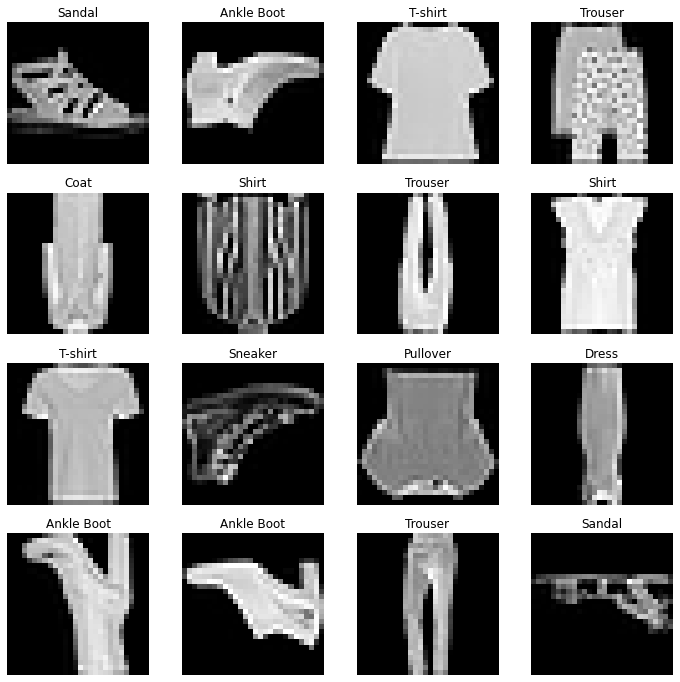

In [9]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

figure=plt.figure(figsize=(12,12))
cols,rows=4,4
for i in range(1,cols*rows+1):
    image=images[i].squeeze()
    label_idx=labels[i].item()
    label=classes[label_idx]

    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image,cmap='gray')

plt.show()

In [10]:
from torch import Tensor

In [11]:
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: Tensor) -> Tensor:
        # pytorch version >= 0.9.0
        # x = x.permute(0, 2, 3, 1)
        # x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        # x = x.permute(0, 3, 1, 2)

        # pytorch version < 0.9.0
        x = x.transpose(1,2)
        x = x.transpose(2,3)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.transpose(2,3)
        x = x.transpose(1,2)
        return x

In [12]:
model=models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# 모델 일부만 사용 
model.features=nn.Sequential(*list(model.features.children())[0:6])
model.avgpool=nn.Identity()
model.classifier=nn.Identity()

학습된 weight 일부 삭제

In [10]:
d=model_zoo.load_url(model_urls['resnet50'])

def remove(key):
    del d[key]
    return d

remove_list=['layer4.0.conv1.weight', 'layer4.0.bn1.running_mean', 'layer4.0.bn1.running_var', 'layer4.0.bn1.weight', 'layer4.0.bn1.bias', 'layer4.0.conv2.weight', 'layer4.0.bn2.running_mean', 'layer4.0.bn2.running_var', 'layer4.0.bn2.weight', 'layer4.0.bn2.bias', 'layer4.0.conv3.weight', 'layer4.0.bn3.running_mean', 'layer4.0.bn3.running_var', 'layer4.0.bn3.weight', 'layer4.0.bn3.bias', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.1.conv1.weight', 'layer4.1.bn1.running_mean', 'layer4.1.bn1.running_var', 'layer4.1.bn1.weight', 'layer4.1.bn1.bias', 'layer4.1.conv2.weight', 'layer4.1.bn2.running_mean', 'layer4.1.bn2.running_var', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'layer4.1.conv3.weight', 'layer4.1.bn3.running_mean', 'layer4.1.bn3.running_var', 'layer4.1.bn3.weight', 'layer4.1.bn3.bias', 'layer4.2.conv1.weight', 'layer4.2.bn1.running_mean', 'layer4.2.bn1.running_var', 'layer4.2.bn1.weight', 'layer4.2.bn1.bias', 'layer4.2.conv2.weight', 'layer4.2.bn2.running_mean', 'layer4.2.bn2.running_var', 'layer4.2.bn2.weight', 'layer4.2.bn2.bias', 'layer4.2.conv3.weight', 'layer4.2.bn3.running_mean', 'layer4.2.bn3.running_var', 'layer4.2.bn3.weight', 'layer4.2.bn3.bias', 'fc.weight', 'fc.bias']

for i in range(len(remove_list)):
    remove(remove_list[i])

학습된 모델 생성 코드 (실험에서는 적용 x)

In [11]:
# 모델 정의 (수정된 ResNet50)
model = ResidualNet("ImageNet",50,1000,None)

# 학습된 weight 불러오기
# model.load_state_dict(d, strict=False)

# GPU 환경에서 연산
model.to(device)

/home/ahnsunghyun/pytorch/ResNet/model_resnet.py:134: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
 

모델 확인

In [12]:
input=torch.zeros(128, 3, 28, 28).to(device)
print(pytorch_model_summary.summary(model, input, show_input=True))
print(model.parameters)

-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [128, 3, 28, 28]           9,408           9,408
     BatchNorm2d-2     [128, 64, 14, 14]             128             128
            ReLU-3     [128, 64, 14, 14]               0               0
       MaxPool2d-4     [128, 64, 14, 14]               0               0
      Bottleneck-5       [128, 64, 7, 7]          75,008          75,008
      Bottleneck-6      [128, 256, 7, 7]          70,400          70,400
      Bottleneck-7      [128, 256, 7, 7]          70,400          70,400
      Bottleneck-8      [128, 256, 7, 7]         379,392         379,392
      Bottleneck-9      [128, 512, 4, 4]         280,064         280,064
     Bottleneck-10      [128, 512, 4, 4]         280,064         280,064
     Bottleneck-11      [128, 512, 4, 4]         280,064         280,064
     Bottleneck-12      [128, 512, 4, 4]       1,5

/home/ahnsunghyun/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


나의 모델 정의

In [16]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.upsample=nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        self.conv=nn.Conv2d(1,3,3)
        self.batchN=nn.BatchNorm2d(3)
        self.network=model
        self.layernorm=LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
        self.cbam = CBAM(384, 16) # CBAM
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(384, 384),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(384, 10)
        )
        
    def forward(self,x):
        x=self.upsample(x)
        x=F.relu(self.conv(x))
        x=self.batchN(x)
        x=self.network(x)
        x=self.cbam(x)
        x=self.max_pool(x)
        x = torch.flatten(x, 1)
        x=self.fc_layer(x)
        return x

In [17]:
mynet=MyNet()
mynet.to(device)

MyNet(
  (upsample): Upsample(scale_factor=2.0, mode=bicubic)
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (batchN): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (network): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU()
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
    

나의 모델 확인

In [18]:
input=torch.zeros(1,1,28,28).to(device)
print(pytorch_model_summary.summary(mynet, input, show_input=True))
print(type(mynet(input)))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
        Upsample-1      [1, 1, 28, 28]               0               0
          Conv2d-2      [1, 1, 56, 56]              30              30
     BatchNorm2d-3      [1, 3, 54, 54]               6               6
        ConvNeXt-4      [1, 3, 54, 54]      12,348,000      12,348,000
            CBAM-5      [1, 384, 3, 3]          18,940          18,940
       MaxPool2d-6      [1, 384, 3, 3]               0               0
         Dropout-7            [1, 384]               0               0
          Linear-8            [1, 384]         147,840         147,840
            ReLU-9            [1, 384]               0               0
        Dropout-10            [1, 384]               0               0
         Linear-11            [1, 384]           3,850           3,850
Total params: 12,518,666
Trainable params: 12,518,666
Non-trainable params: 

/home/ahnsunghyun/.local/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


손실함수와 옵티마이저

In [19]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(mynet.parameters(), lr=0.0001, eps=1e-08)

모델 학습

In [20]:
batch_size=128 # 학습할 때 얼마나 많은 데이터를 이용할 것인가 
steps_per_epoch=len(train_loader) # 한 epoch 당 스텝 수 (batch_size크기의 데이터 개수)

# epoch 수는 50
for epoch in range(100):
    running_loss=0.0 # 초기 누적 오차 = 0 
    batch_acc_list=[] # batch 별 accuracy list

    # step (steps_per_epoch:469)
    for i, data in enumerate(train_loader,0):
        # 데이터 입력
        inputs, labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # Gradient -> 0
        optimizer.zero_grad()
        # 순전파+역전파+최적화 
        outputs=mynet(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # 누적 오차 
        running_loss +=loss.item()

        # batch_accuracy 계산 (한 스텝마다 accuracy 저장)
        _,predicted=torch.max(outputs.data,1)
        correct=(predicted==labels).sum().item()
        batch_acc = correct/batch_size * 100
        batch_acc_list.append(batch_acc)

        if i % 100 == 99:
            print('Epoch: {}, Iter: {}, Loss:{}'.format(epoch+1,i+1,running_loss/steps_per_epoch))
            running_loss=0.0

    # epoch마다 accuracy 출력
    epoch_acc=np.mean(batch_acc_list) # batch_accuracy_list의 평균으로 계산 (전체 데이터를 기준)
    print('Epoch: {}, Acc:{}'.format(epoch+1,epoch_acc))
        

Epoch: 1, Iter: 100, Loss:0.24457577341146816
Epoch: 1, Iter: 200, Loss:0.09615004431210093
Epoch: 1, Iter: 300, Loss:0.08045083824505429
Epoch: 1, Iter: 400, Loss:0.06712215563762924
Epoch: 1, Acc:82.36773720682302
Epoch: 2, Iter: 100, Loss:0.055834867139614976
Epoch: 2, Iter: 200, Loss:0.05312608198316367
Epoch: 2, Iter: 300, Loss:0.05147835543986831
Epoch: 2, Iter: 400, Loss:0.049015825983684966
Epoch: 2, Acc:91.46788379530916
Epoch: 3, Iter: 100, Loss:0.04400282786853278
Epoch: 3, Iter: 200, Loss:0.04441433185453354
Epoch: 3, Iter: 300, Loss:0.042933810510233775
Epoch: 3, Iter: 400, Loss:0.04294714430120708
Epoch: 3, Acc:92.90045309168444
Epoch: 4, Iter: 100, Loss:0.03783759015646062
Epoch: 4, Iter: 200, Loss:0.03712905317481393
Epoch: 4, Iter: 300, Loss:0.038921091268692955
Epoch: 4, Iter: 400, Loss:0.03569190880891357
Epoch: 4, Acc:93.84661513859275
Epoch: 5, Iter: 100, Loss:0.03337748329649602
Epoch: 5, Iter: 200, Loss:0.03449981407061823
Epoch: 5, Iter: 300, Loss:0.032581604365

모델 테스트

In [28]:
correct=0
total=0

with torch.no_grad():
    for data in test_loader:
        images, labels=data
        images=images.to(device)
        labels=labels.to(device)
        outputs=mynet(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(correct/total*100)

93.72
